In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import IterableDataset
import numpy as np
from tqdm import tqdm
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import matplotlib.pyplot as plt
import gc
import xbatcher
# import Geohash
import os

In [5]:
# just fingerprints (output from David's code)
fingerprint_file = '../../data/SSH_Patterns.nc'

# full ocean dynamics (output from Sonke's code)
ocean_dynmaics_file = '../../data/GLORYS_Surrogate_Combined_40320sims.nc'

In [6]:
# synthetic fingerprints dataset
fingerprints = xr.open_dataset(fingerprint_file)

#### Visualize Synthetic Fingerprints

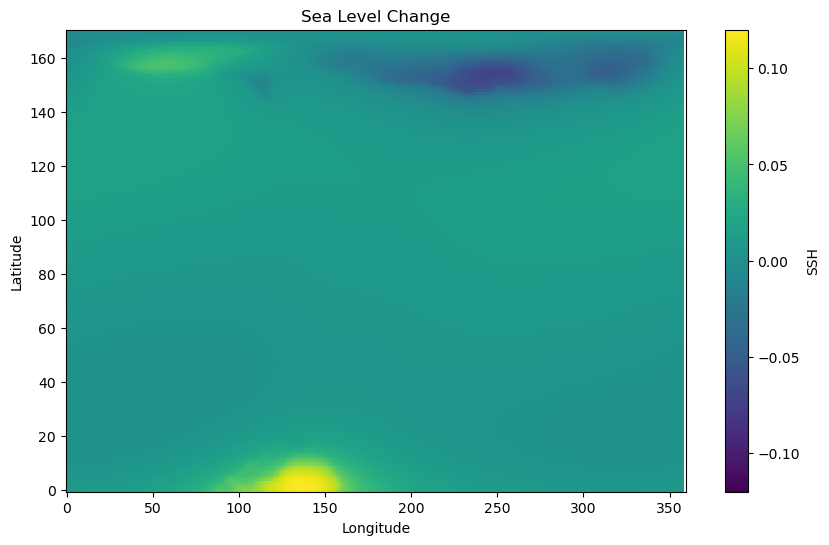

In [7]:
# Select timestep/simualtion number
fingerprint_data_slice = fingerprints['SSH'].isel(time=1, nsim=1)

plt.figure(figsize=(10, 6))
fingerprint_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
# synthetic ocean dynamics dataset
ocean_dynamics = xr.open_dataset(ocean_dynmaics_file)

#### Visualize Synthetic Ocean Dynamics Field

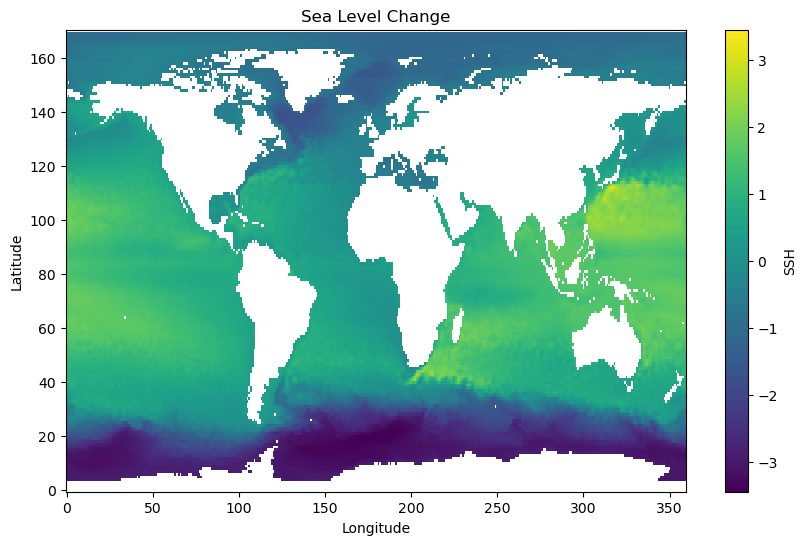

In [9]:
# Select timestep/simualtion number
surrogate_data_slice = ocean_dynamics['SSH'].isel(time=0, nsim=0)

plt.figure(figsize=(10, 6))
surrogate_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
print(ocean_dynamics['time'])
print('-'*80)
print(fingerprints['time'])

<xarray.DataArray 'time' (time: 336)>
array([1993.    , 1993.0834, 1993.1666, ..., 2020.75  , 2020.8334, 2020.9166],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.993e+03 1.993e+03 ... 2.021e+03 2.021e+03
--------------------------------------------------------------------------------
<xarray.DataArray 'time' (time: 336)>
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Coordinates:
  * time     (time) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36


In [11]:
# time columns scaled differently
ocean_dynamics['time'] = fingerprints['time']

In [12]:
synthetics = fingerprints.copy()
synthetics['SSH'] = fingerprints['SSH'] + ocean_dynamics['SSH']

#### Visualize Full Synthetic Field

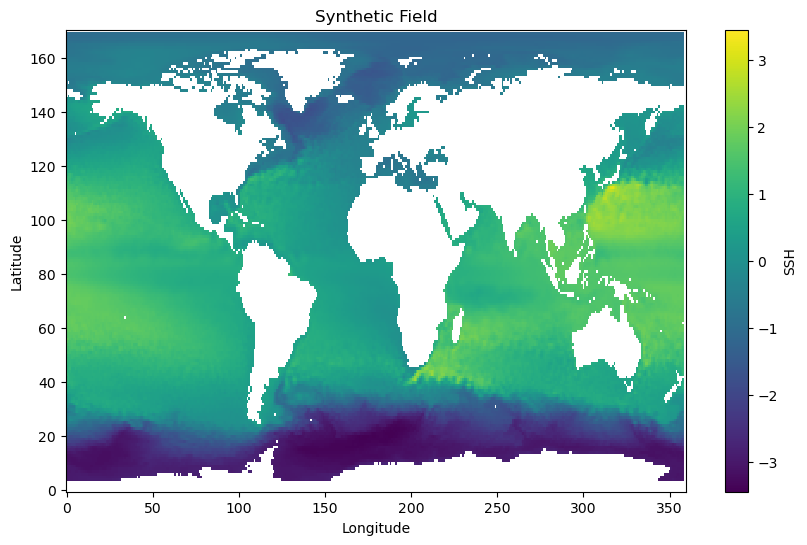

In [13]:
combined_ssh_slice = synthetics['SSH'].isel(time=0, nsim=0)
plt.figure(figsize=(10, 6))
combined_ssh_slice.plot(cmap='viridis')
plt.title('Synthetic Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Generate batches of data for training. Input_gen full ocean dynamics combined with fingerprints and target_gen contains only fingerprint (our model's prediction targets)

In [14]:
# Define the starting indices for latitude and longitude for your 5x5 patch
lat_start = 30
lon_start = 175

# Select the 5x5-degree patch from both datasets (synthetics and fingerprints)
input_patch = synthetics.isel(lat=slice(lat_start, lat_start + 5), lon=slice(lon_start, lon_start + 5))
target_patch = fingerprints.isel(lat=slice(lat_start, lat_start + 5), lon=slice(lon_start, lon_start + 5))

In [15]:
# Collapse 'time' and 'nsim' into a single 'sim' dimension for input and target patches
input_patch_collapsed = input_patch.stack(sim=('time', 'nsim'))
target_patch_collapsed = target_patch.stack(sim=('time', 'nsim'))

# Check the new dimensions
print(input_patch_collapsed.dims)
print(target_patch_collapsed.dims)

Frozen({'lat': 5, 'lon': 5, 'sim': 40320})
Frozen({'lat': 5, 'lon': 5, 'sim': 40320})


#### Train/Validation splits

In [16]:
# Define the split index for train/validation based on the new 'sim' dimension
split_idx = int(0.8 * input_patch_collapsed.sizes['sim'])

# Training set (80% of the 'sim' dimension)
input_train = input_patch_collapsed.isel(sim=slice(0, split_idx))
target_train = target_patch_collapsed.isel(sim=slice(0, split_idx))

# Validation set (remaining 20% of the 'sim' dimension)
input_val = input_patch_collapsed.isel(sim=slice(split_idx, None))
target_val = target_patch_collapsed.isel(sim=slice(split_idx, None))


#### Create Batch Generators

In [17]:
# BatchGenerators for the training set (collapsed data)
train_input_gen = xbatcher.BatchGenerator(input_train, {'sim': split_idx, 'lat': 5, 'lon': 5})
train_target_gen = xbatcher.BatchGenerator(target_train, {'sim': split_idx, 'lat': 5, 'lon': 5})

# BatchGenerators for the validation set (collapsed data)
val_input_gen = xbatcher.BatchGenerator(input_val, {'sim': input_val.sizes['sim'], 'lat': 5, 'lon': 5})
val_target_gen = xbatcher.BatchGenerator(target_val, {'sim': input_val.sizes['sim'], 'lat': 5, 'lon': 5})


In [169]:
# Example of iterating through training batches
for input_batch, target_batch in zip(train_input_gen, train_target_gen):
    # Use input_batch and target_batch to train your CNN
    print("Input batch shape:", input_batch['SSH'].shape)
    print("Target batch shape:", target_batch['SSH'].shape)
    print("Input patch dimensions ['SSH']:", input_patch['SSH'].dims)
    print("Target patch dimensions ['SSH']:", target_patch['SSH'].dims)
    print("Input patch dimensions:", input_patch.dims)
    print("Target patch dimensions:", target_patch.dims)

Input batch shape: (5, 5, 32256)
Target batch shape: (5, 5, 32256)
Input patch dimensions ['SSH']: ('time', 'lat', 'lon', 'nsim')
Target patch dimensions ['SSH']: ('time', 'lat', 'lon', 'nsim')
Input patch dimensions: FrozenMappingWarningOnValuesAccess({'lat': 5, 'lon': 5, 'time': 336, 'nsim': 120})
Target patch dimensions: FrozenMappingWarningOnValuesAccess({'lat': 5, 'lon': 5, 'time': 336, 'nsim': 120})


In [148]:
# Function to visualize input, prediction, and target for multiple samples
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the enhanced CNN model with pooling layer and global average pooling
class EnhancedFingerprintCNN(nn.Module):
    def __init__(self):
        super(EnhancedFingerprintCNN, self).__init__()
        # First set of convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
        # Global average pooling (replaces the second pooling layer)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
    
    def _forward_conv_layers(self, x):
        # First set of convolutions + batch norm + pooling
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Second set of convolutions + batch norm
        x = self.bn3(torch.relu(self.conv3(x)))
        
        # Apply global average pooling instead of max pooling
        x = self.global_avg_pool(x)
        
        return x
    
    def forward(self, x):
        # Forward pass through conv layers
        x = self._forward_conv_layers(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout and ReLU
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        
        return x

# Visualization function
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

# Instantiate the enhanced model, loss function, optimizer, and scheduler
model = EnhancedFingerprintCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# StepLR scheduler: decay LR by a factor of 0.5 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for input_batch, target_batch in zip(train_input_gen, train_target_gen):
        # Reshape the input batch
        inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
        targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Step the scheduler after every epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(inputs, predictions, targets, num_examples=5)


Epoch [1/40], Loss: 0.0037761034909635782, Learning Rate: 0.003
Epoch [2/40], Loss: 0.0011505348375067115, Learning Rate: 0.003
Epoch [3/40], Loss: 0.00036886491579934955, Learning Rate: 0.003
Epoch [4/40], Loss: 0.0003139884793199599, Learning Rate: 0.003
Epoch [5/40], Loss: 0.0003896455164067447, Learning Rate: 0.003
Epoch [6/40], Loss: 0.0003180069907102734, Learning Rate: 0.003
Epoch [7/40], Loss: 0.00023847693228162825, Learning Rate: 0.003
Epoch [8/40], Loss: 0.0002228222438134253, Learning Rate: 0.003
Epoch [9/40], Loss: 0.0002215993736172095, Learning Rate: 0.003
Epoch [10/40], Loss: 0.00020490241877269, Learning Rate: 0.0006000000000000001
Epoch [11/40], Loss: 0.00018005562014877796, Learning Rate: 0.0006000000000000001
Epoch [12/40], Loss: 0.00017484153795521706, Learning Rate: 0.0006000000000000001
Epoch [13/40], Loss: 0.00016754676471464336, Learning Rate: 0.0006000000000000001
Epoch [14/40], Loss: 0.00015995348803699017, Learning Rate: 0.0006000000000000001
Epoch [15/40], 

Epoch [1/40], Loss: 0.0036618495360016823, Learning Rate: 0.003
Epoch [2/40], Loss: 0.0010877526365220547, Learning Rate: 0.003
Epoch [3/40], Loss: 0.0005815356271341443, Learning Rate: 0.003
Epoch [4/40], Loss: 0.00019424593483563513, Learning Rate: 0.003
Epoch [5/40], Loss: 0.00022514427837450057, Learning Rate: 0.003
Epoch [6/40], Loss: 0.00022485524823423475, Learning Rate: 0.003
Epoch [7/40], Loss: 0.00020057166693732142, Learning Rate: 0.003
Epoch [8/40], Loss: 0.0001942880917340517, Learning Rate: 0.003
Epoch [9/40], Loss: 0.00018535766866989434, Learning Rate: 0.003
Epoch [10/40], Loss: 0.0001705846661934629, Learning Rate: 0.0006000000000000001
Epoch [11/40], Loss: 0.00015587829693686217, Learning Rate: 0.0006000000000000001
Epoch [12/40], Loss: 0.00015271520533133298, Learning Rate: 0.0006000000000000001
Epoch [13/40], Loss: 0.00014841652591712773, Learning Rate: 0.0006000000000000001
Epoch [14/40], Loss: 0.00014348932018037885, Learning Rate: 0.0006000000000000001
Epoch [15/

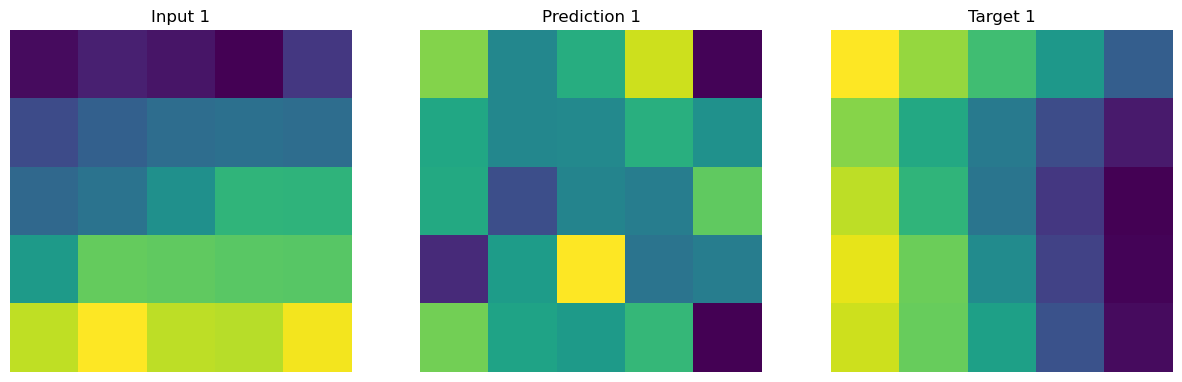

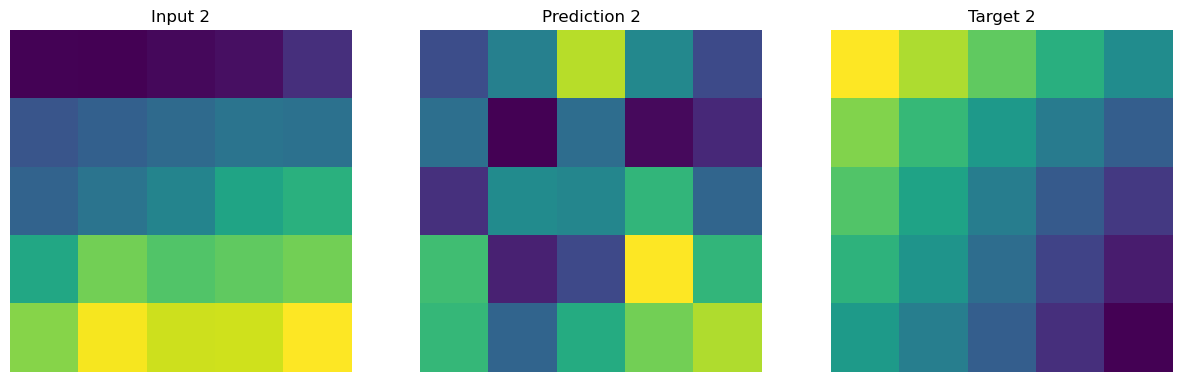

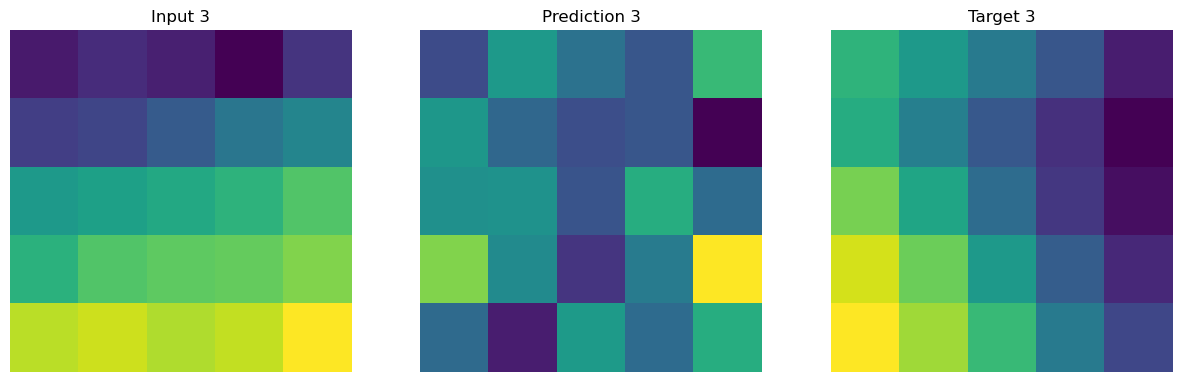

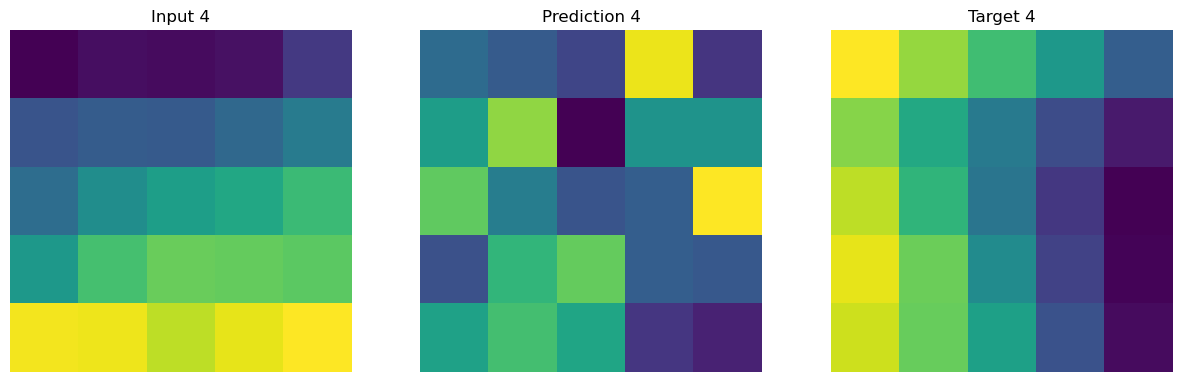

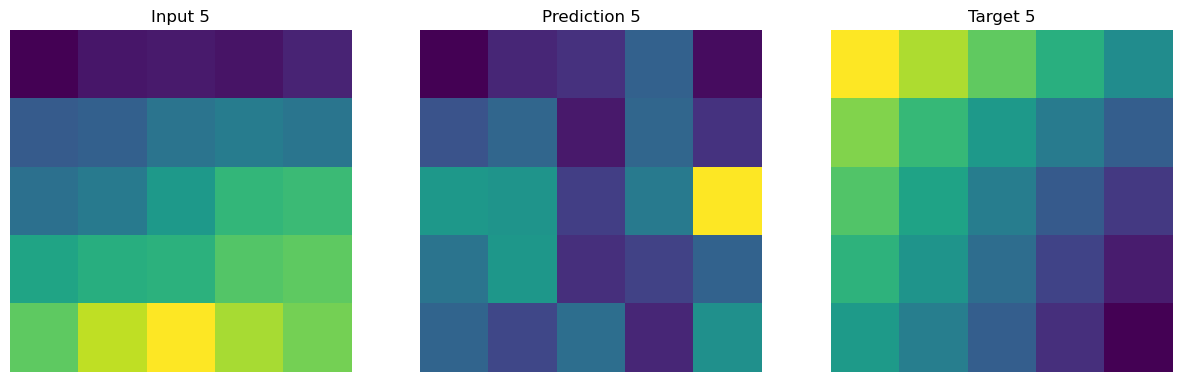

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the enhanced CNN model with pooling layer and global average pooling
class EnhancedFingerprintCNN(nn.Module):
    def __init__(self):
        super(EnhancedFingerprintCNN, self).__init__()
        # First set of convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
        # Global average pooling (replaces the second pooling layer)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
    
    def _forward_conv_layers(self, x):
        # First set of convolutions + batch norm + pooling
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Second set of convolutions + batch norm
        x = self.bn3(torch.relu(self.conv3(x)))
        
        # Apply global average pooling instead of max pooling
        x = self.global_avg_pool(x)
        
        return x
    
    def forward(self, x):
        # Forward pass through conv layers
        x = self._forward_conv_layers(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout and ReLU
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        
        return x

# Visualization function
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

# Instantiate the enhanced model, loss function, optimizer, and scheduler
model = EnhancedFingerprintCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# StepLR scheduler: decay LR by a factor of 0.5 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for input_batch, target_batch in zip(train_input_gen, train_target_gen):
        # Reshape the input batch
        inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
        targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Step the scheduler after every epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(inputs, predictions, targets, num_examples=5)


Epoch [1/40], Loss: 0.0037790422793477774, Learning Rate: 0.003
Epoch [2/40], Loss: 0.0013504497474059463, Learning Rate: 0.003
Epoch [3/40], Loss: 0.0004452152061276138, Learning Rate: 0.003
Epoch [4/40], Loss: 0.00024236452009063214, Learning Rate: 0.003
Epoch [5/40], Loss: 0.00032064132392406464, Learning Rate: 0.003
Epoch [6/40], Loss: 0.0002587430935818702, Learning Rate: 0.003
Epoch [7/40], Loss: 0.00020782867795787752, Learning Rate: 0.003
Epoch [8/40], Loss: 0.0001995091006392613, Learning Rate: 0.003
Epoch [9/40], Loss: 0.00018540534074418247, Learning Rate: 0.003
Epoch [10/40], Loss: 0.00016350015357602388, Learning Rate: 0.0006000000000000001
Epoch [11/40], Loss: 0.00015641127538401634, Learning Rate: 0.0006000000000000001
Epoch [12/40], Loss: 0.00015547097427770495, Learning Rate: 0.0006000000000000001
Epoch [13/40], Loss: 0.00015213417646009475, Learning Rate: 0.0006000000000000001
Epoch [14/40], Loss: 0.0001474055170547217, Learning Rate: 0.0006000000000000001
Epoch [15/4

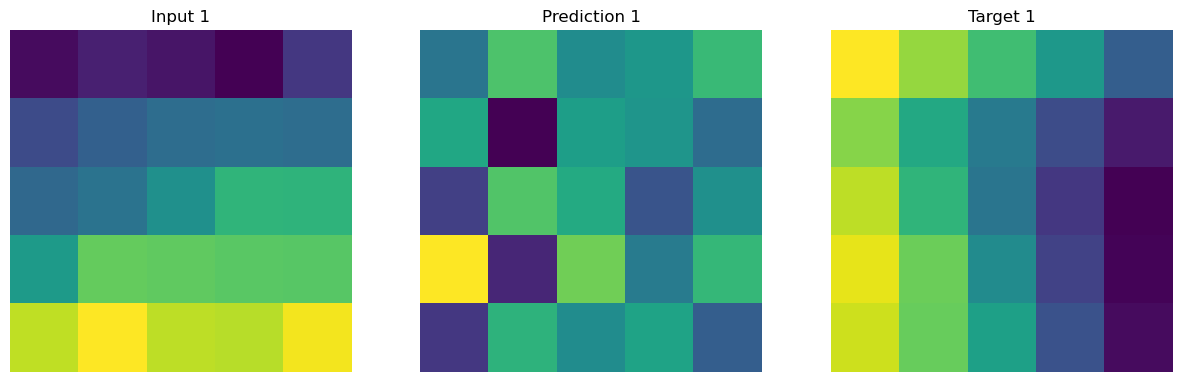

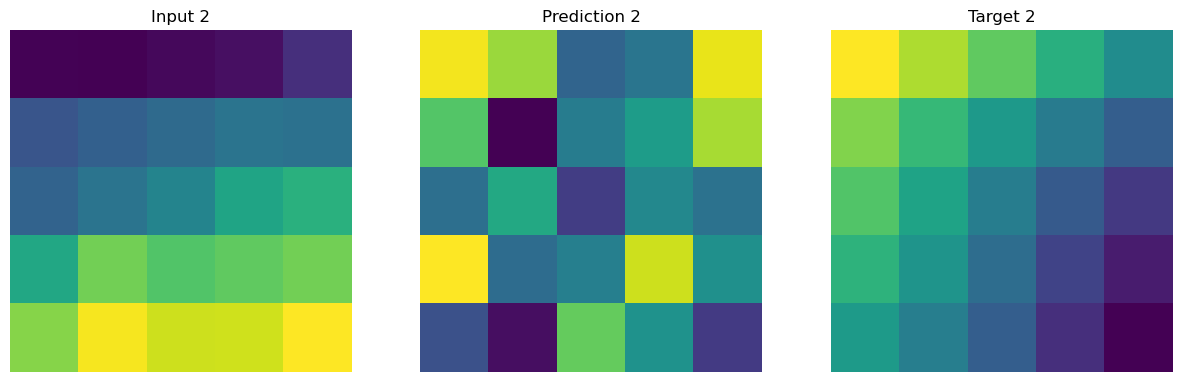

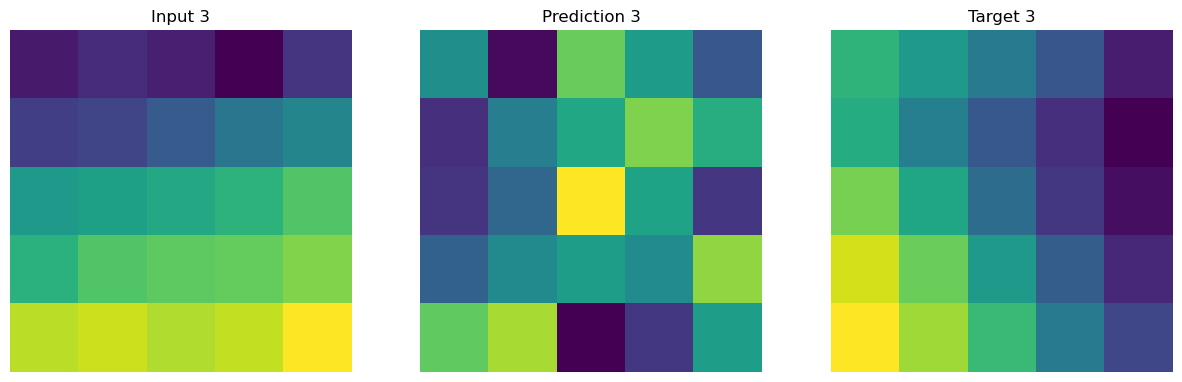

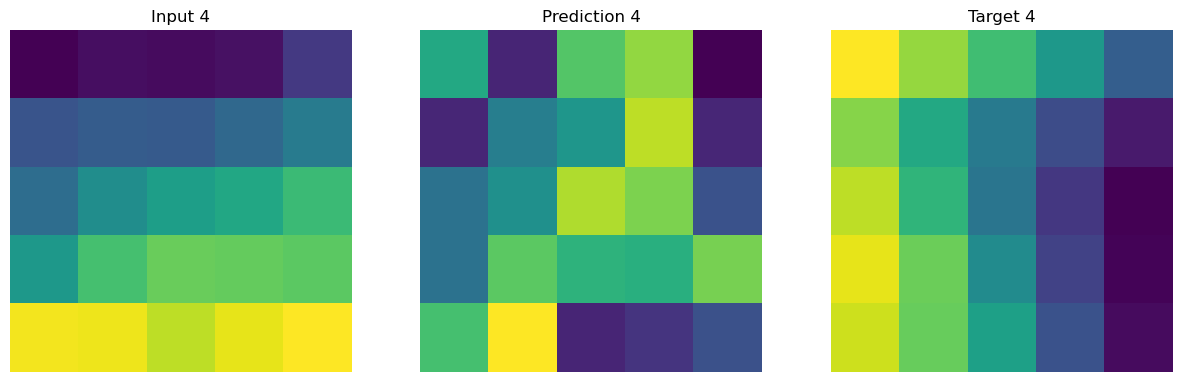

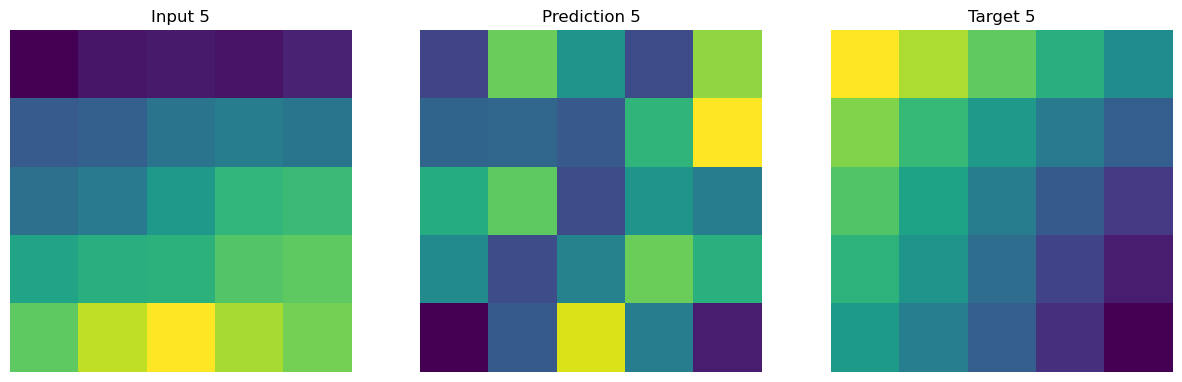

In [210]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the enhanced CNN model with pooling layer and global average pooling
class EnhancedFingerprintCNN(nn.Module):
    def __init__(self):
        super(EnhancedFingerprintCNN, self).__init__()
        # First set of convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
        # Global average pooling (replaces the second pooling layer)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
    
    def _forward_conv_layers(self, x):
        # First set of convolutions + batch norm + pooling
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Second set of convolutions + batch norm
        x = self.bn3(torch.relu(self.conv3(x)))
        
        # Apply global average pooling instead of max pooling
        x = self.global_avg_pool(x)
        
        return x
    
    def forward(self, x):
        # Forward pass through conv layers
        x = self._forward_conv_layers(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout and ReLU
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        
        return x

# Visualization function
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

# Instantiate the enhanced model, loss function, optimizer, and scheduler
model = EnhancedFingerprintCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# StepLR scheduler: decay LR by a factor of 0.5 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for input_batch, target_batch in zip(train_input_gen, train_target_gen):
        # Reshape the input batch
        inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
        targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Step the scheduler after every epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(inputs, predictions, targets, num_examples=5)


Epoch [1/40], Loss: 0.0041913362219929695, Learning Rate: 0.003
Epoch [2/40], Loss: 0.0012516395654529333, Learning Rate: 0.003
Epoch [3/40], Loss: 0.0004120185330975801, Learning Rate: 0.003
Epoch [4/40], Loss: 0.00019990498549304903, Learning Rate: 0.003
Epoch [5/40], Loss: 0.0002705265360418707, Learning Rate: 0.003
Epoch [6/40], Loss: 0.00025858363369479775, Learning Rate: 0.003
Epoch [7/40], Loss: 0.00020997607498429716, Learning Rate: 0.003
Epoch [8/40], Loss: 0.00019209763559047133, Learning Rate: 0.003
Epoch [9/40], Loss: 0.000189405502169393, Learning Rate: 0.003
Epoch [10/40], Loss: 0.00017655322153586894, Learning Rate: 0.0006000000000000001
Epoch [11/40], Loss: 0.00015601443010382354, Learning Rate: 0.0006000000000000001
Epoch [12/40], Loss: 0.00015173046267591417, Learning Rate: 0.0006000000000000001
Epoch [13/40], Loss: 0.00014633696991950274, Learning Rate: 0.0006000000000000001
Epoch [14/40], Loss: 0.00014086568262428045, Learning Rate: 0.0006000000000000001
Epoch [15/4

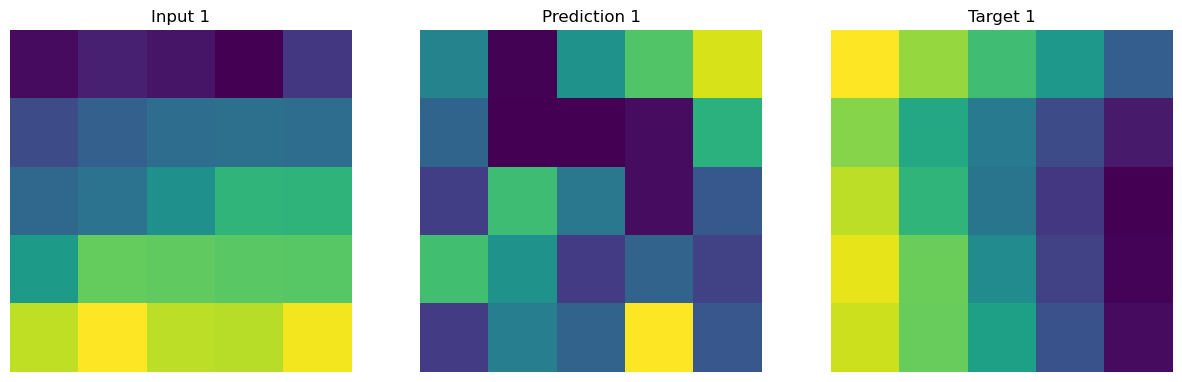

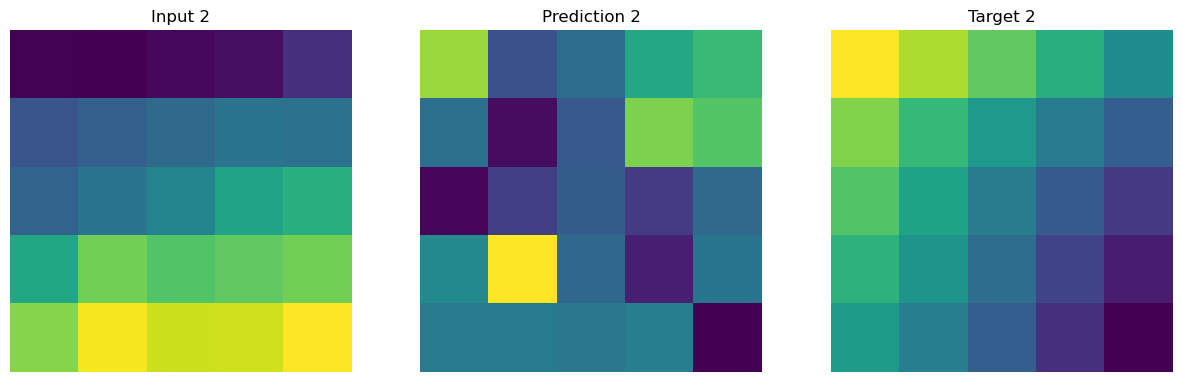

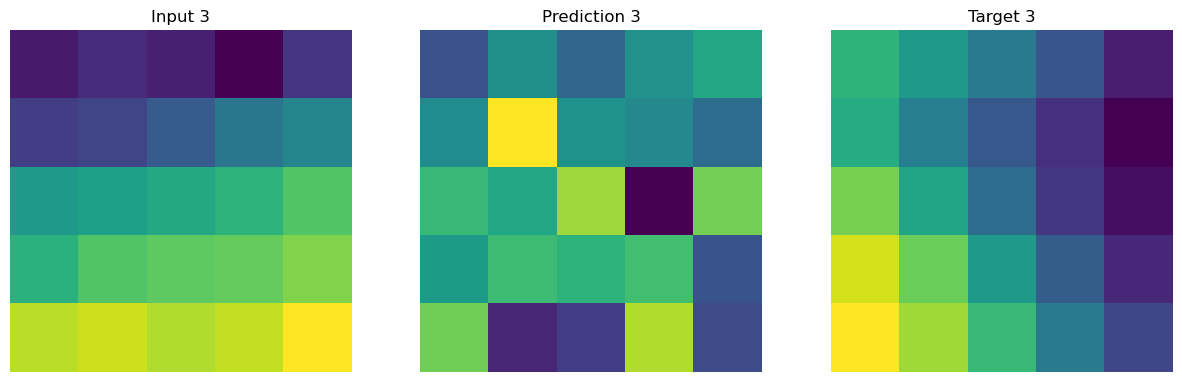

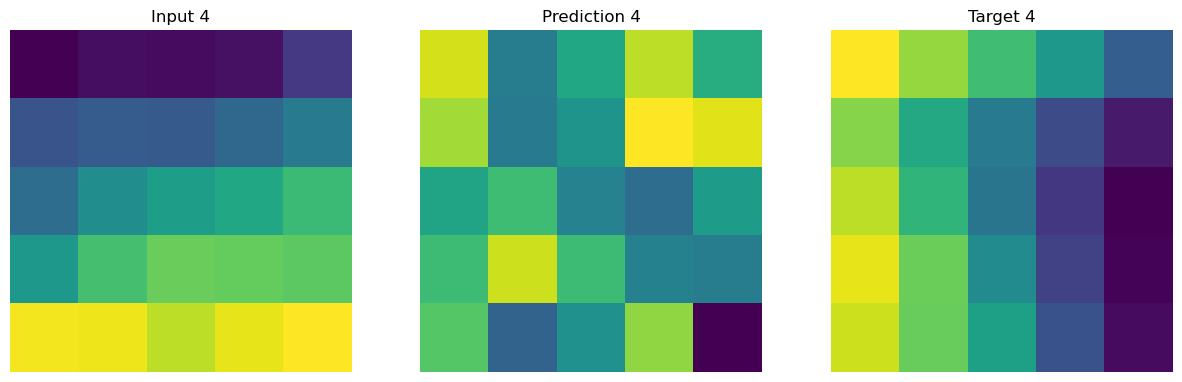

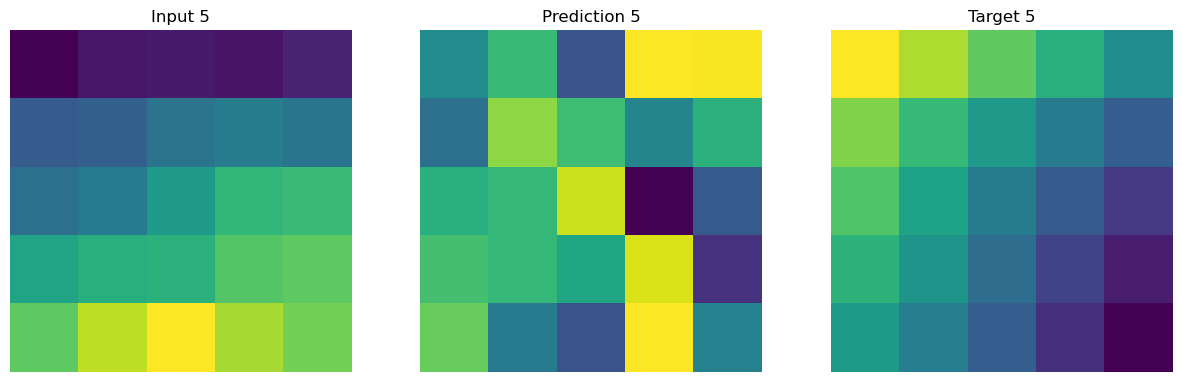

In [209]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the enhanced CNN model with pooling layer and global average pooling
class EnhancedFingerprintCNN(nn.Module):
    def __init__(self):
        super(EnhancedFingerprintCNN, self).__init__()
        # First set of convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
        # Global average pooling (replaces the second pooling layer)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
    
    def _forward_conv_layers(self, x):
        # First set of convolutions + batch norm + pooling
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Second set of convolutions + batch norm
        x = self.bn3(torch.relu(self.conv3(x)))
        
        # Apply global average pooling instead of max pooling
        x = self.global_avg_pool(x)
        
        return x
    
    def forward(self, x):
        # Forward pass through conv layers
        x = self._forward_conv_layers(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout and ReLU
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        
        return x

# Visualization function
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

# Instantiate the enhanced model, loss function, optimizer, and scheduler
model = EnhancedFingerprintCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# StepLR scheduler: decay LR by a factor of 0.5 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for input_batch, target_batch in zip(train_input_gen, train_target_gen):
        # Reshape the input batch
        inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
        targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Step the scheduler after every epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(inputs, predictions, targets, num_examples=5)


Epoch [1/40], Loss: 0.10391845554113388, Learning Rate: 0.001
Epoch [2/40], Loss: 0.07241722196340561, Learning Rate: 0.001
Epoch [3/40], Loss: 0.05075917765498161, Learning Rate: 0.001
Epoch [4/40], Loss: 0.041203394532203674, Learning Rate: 0.001
Epoch [5/40], Loss: 0.028730317950248718, Learning Rate: 0.001
Epoch [6/40], Loss: 0.021040957421064377, Learning Rate: 0.001
Epoch [7/40], Loss: 0.016436221078038216, Learning Rate: 0.001
Epoch [8/40], Loss: 0.014006340876221657, Learning Rate: 0.001
Epoch [9/40], Loss: 0.01172935776412487, Learning Rate: 0.001
Epoch [10/40], Loss: 0.009560763835906982, Learning Rate: 0.0003
Epoch [11/40], Loss: 0.008001303300261497, Learning Rate: 0.0003
Epoch [12/40], Loss: 0.00748071912676096, Learning Rate: 0.0003
Epoch [13/40], Loss: 0.006954845041036606, Learning Rate: 0.0003
Epoch [14/40], Loss: 0.006657532416284084, Learning Rate: 0.0003
Epoch [15/40], Loss: 0.006608473137021065, Learning Rate: 0.0003
Epoch [16/40], Loss: 0.006599835120141506, Learn

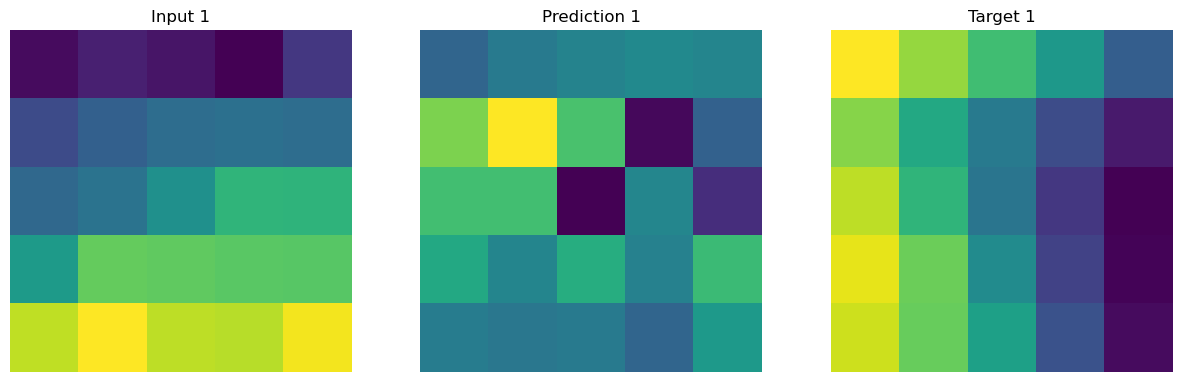

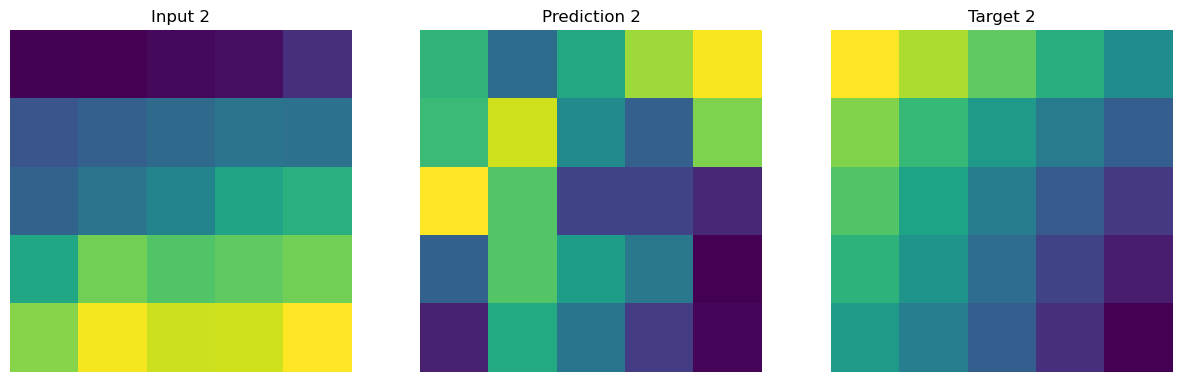

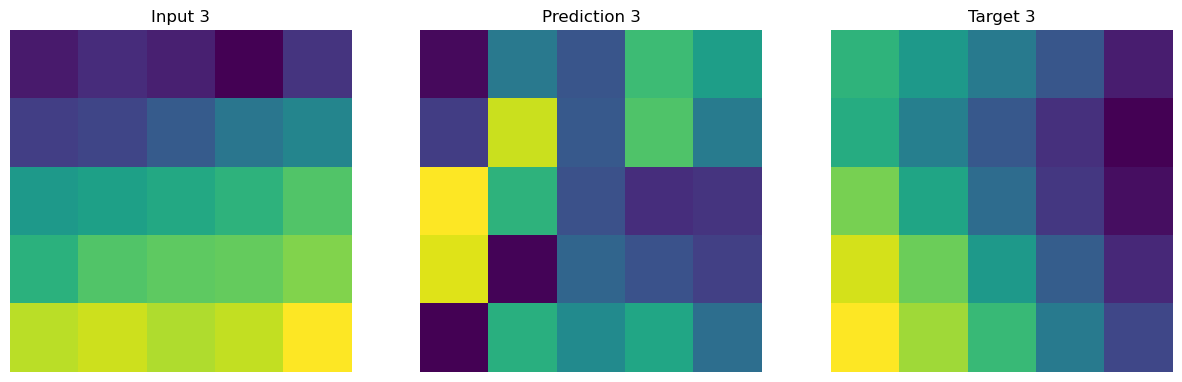

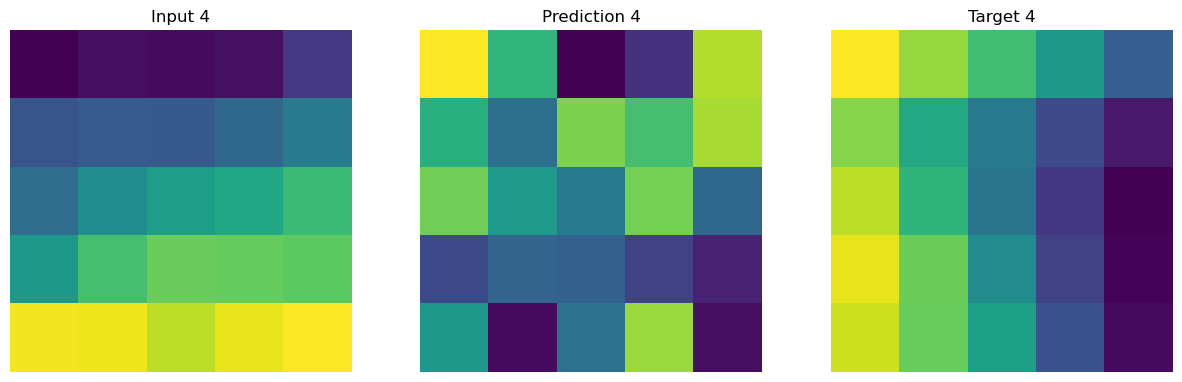

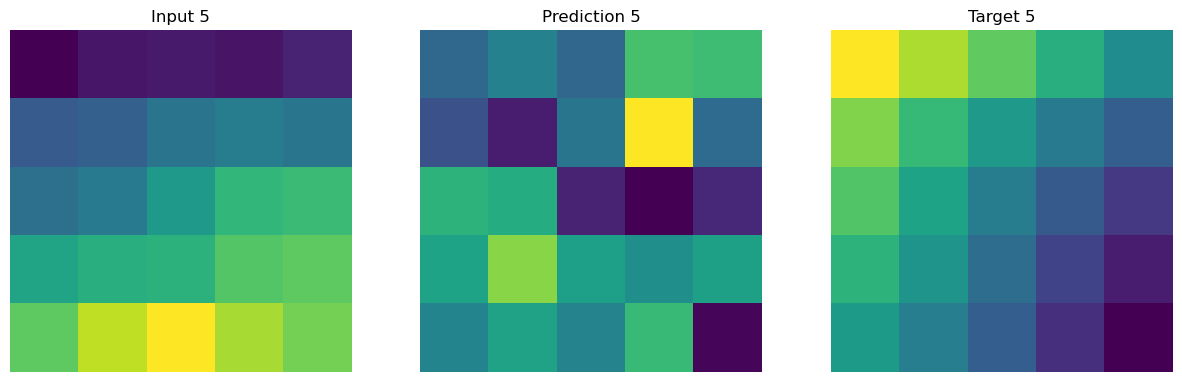

In [194]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the enhanced CNN model with pooling layer and global average pooling
class EnhancedFingerprintCNN(nn.Module):
    def __init__(self):
        super(EnhancedFingerprintCNN, self).__init__()
        # First set of convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window
        
        # Global average pooling (replaces the second pooling layer)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 25)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
    
    def _forward_conv_layers(self, x):
        # First set of convolutions + batch norm + pooling
        x = self.bn1(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Second set of convolutions + batch norm
        x = self.bn3(torch.relu(self.conv3(x)))
        
        # Apply global average pooling instead of max pooling
        x = self.global_avg_pool(x)
        
        return x
    
    def forward(self, x):
        # Forward pass through conv layers
        x = self._forward_conv_layers(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout and ReLU
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        
        return x

# Loss Functions
def smooth_l1_loss(predictions, targets):
    return nn.SmoothL1Loss()(predictions, targets)

def total_variation_loss(predictions):
    tv_loss = torch.sum(torch.abs(predictions[:, :, :, :-1] - predictions[:, :, :, 1:])) + \
              torch.sum(torch.abs(predictions[:, :, :-1, :] - predictions[:, :, 1:, :]))
    return tv_loss

def laplacian_loss(predictions):
    laplacian_filter = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]]).float().unsqueeze(0).unsqueeze(0).to(predictions.device)
    laplacian = nn.functional.conv2d(predictions, laplacian_filter, padding=1)
    return torch.mean(torch.abs(laplacian))

def gradient_loss(predictions, targets):
    # Reshape predictions and targets back to (batch_size, 1, 5, 5)
    predictions = predictions.view(-1, 1, 5, 5)
    targets = targets.view(-1, 1, 5, 5)

    # Calculate gradient differences along the x and y axes
    diff_x_pred = torch.abs(predictions[:, :, 1:, :] - predictions[:, :, :-1, :])
    diff_y_pred = torch.abs(predictions[:, :, :, 1:] - predictions[:, :, :, :-1])

    diff_x_true = torch.abs(targets[:, :, 1:, :] - targets[:, :, :-1, :])
    diff_y_true = torch.abs(targets[:, :, :, 1:] - targets[:, :, :, :-1])

    # Match dimensions by zero-padding on the smaller side for diff_x and diff_y
    diff_x_pred = torch.nn.functional.pad(diff_x_pred, (0, 0, 0, 1))  # Padding along height
    diff_x_true = torch.nn.functional.pad(diff_x_true, (0, 0, 0, 1))

    diff_y_pred = torch.nn.functional.pad(diff_y_pred, (0, 1, 0, 0))  # Padding along width
    diff_y_true = torch.nn.functional.pad(diff_y_true, (0, 1, 0, 0))

    # Compute the gradient loss
    return torch.mean(torch.abs(diff_x_pred - diff_x_true) + torch.abs(diff_y_pred - diff_y_true))



# Visualization function
def visualize_examples(inputs, predictions, targets, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)
        target_sample = targets[i].detach().numpy().reshape(5, 5)  # Reshape to (5, 5)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

# Instantiate the enhanced model, optimizer, and scheduler
model = EnhancedFingerprintCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

# Choose which loss function to use
loss_function_choice = 'gradient_loss'  # 'smooth_l1', 'tv_loss', 'laplacian', 'gradient_loss'

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for input_batch, target_batch in zip(train_input_gen, train_target_gen):
        # Reshape the input batch
        inputs = torch.tensor(input_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1)  # (32256, 1, 5, 5)
        targets = torch.tensor(target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).view(-1, 25)  # (32256, 25)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(inputs)
        
        # Choose the loss function dynamically
        if loss_function_choice == 'smooth_l1':
            loss = smooth_l1_loss(predictions, targets)
        elif loss_function_choice == 'tv_loss':
            loss = nn.MSELoss()(predictions, targets) + total_variation_loss(predictions)
        elif loss_function_choice == 'laplacian':
            loss = nn.MSELoss()(predictions, targets) + laplacian_loss(predictions)
        elif loss_function_choice == 'gradient_loss':
            loss = nn.MSELoss()(predictions, targets) + gradient_loss(predictions, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item()

    # Step the scheduler after every epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_input_gen)}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(inputs, predictions, targets, num_examples=5)
